In [76]:
#!/usr/bin/python
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import matplotlib.cm as cm

#for mem
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [77]:
#read in the original data
df=pd.read_excel('OPHRevisedFig2_HIVDNA_20210921_ADDvloads.xlsx')#,index=False)


In [ ]:
#make the updated dataframe
#note, no need to do this if you're just reading in csv below

cens_l=[]
corr_l=[]
for i in range(len(df)):
    
    tdf=df.iloc[i]
    if tdf['intact_hivdna_per1E6_tcells']==0:
        corr_l.append(1/tdf['total_tcells_interrogated']*1e6/2)
        cens_l.append(1)
    else:
        cens_l.append(0)
        corr_l.append(tdf['intact_hivdna_per1E6_tcells'])
        
df['censoring']=cens_l
df['intact_corrected']=corr_l

df2=df[['short_id', 'time_haart_days','total_hivdna_per1E6_tcells','intact_corrected','vload', 'censoring']]
df2.head()
df3=df2[df2['vload']<100] #simply restrict to current

#make columns in log
df3['ltot']=np.log(df3['total_hivdna_per1E6_tcells'])
df3['lint']=np.log(df3['intact_corrected'])

In [104]:
#previously exported this data and did a little adjustement externally in excel
#df3.to_csv('modeled_data.csv')

df3 = pd.read_csv('modeled_data.csv') #now just read it in
df3 = df3[df3['t_censor']==0] #this restricts to the columns where VL is totally suppressed (ie for more than 6mo)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  ltot    
No. Observations:  14       Method:              REML    
No. Groups:        6        Scale:               0.2421  
Min. group size:   1        Likelihood:          -20.4383
Max. group size:   4        Converged:           Yes     
Mean group size:   2.3                                   
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       5.430    0.483 11.245 0.000  4.484  6.377
time_haart_days 0.000    0.000  1.159 0.246 -0.000  0.001
Group Var       0.240    0.532                           



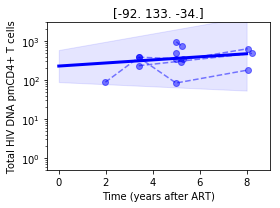

In [106]:

#run MEM
md = smf.mixedlm('ltot ~ time_haart_days', df3, groups=df3['short_id'])
mdf = md.fit()
mem_results=[mdf.params[1],mdf.conf_int().iloc[1,0],mdf.conf_int().iloc[1,1],
             mdf.params[0],mdf.conf_int().iloc[0,0],mdf.conf_int().iloc[0,1]]

#plot total reservoir data relative to initiation of ART
tot_df=df3
dd='total_hivdna_per1E6_tcells'
plt.figure(figsize=(4,3))
simt=np.linspace(0,8,1000)
for ip,p in enumerate(tot_df['short_id'].unique()):
    tdf=tot_df[(tot_df['short_id']==p)]
    plt.plot(tdf['time_haart_days']/365,tdf[dd],color='blue',ls='--',alpha=0.5)#cz_list[pind])
    plt.scatter(tdf['time_haart_days']/365,tdf[dd],marker='o',alpha=0.5,color='blue',edgecolor='blue')#cz_list[pind])
plt.plot(simt,np.exp(mem_results[3]+mem_results[0]*simt*365),color='blue',lw=3)
plt.fill_between(simt,np.exp(mem_results[4]+mem_results[1]*simt*365),np.exp(mem_results[5]+mem_results[2]*simt*365),color='blue',alpha=0.1)
plt.ylabel('Total HIV DNA pmCD4+ T cells')
plt.xticks(range(0,25,5))
plt.xlabel('Time (years after ART)')
plt.semilogy()
plt.ylim([0.5,3e3])
plt.xticks(range(0,23,2))
plt.xlim([-0.5,9])
plt.title(np.round(-np.log(2)/mem_results[:3]/365*12))
plt.tight_layout()    
plt.savefig('longitudinal_total.pdf',dpi=600)


          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  lint    
No. Observations:   14       Method:              REML    
No. Groups:         6        Scale:               0.8860  
Min. group size:    1        Likelihood:          -26.8333
Max. group size:    4        Converged:           Yes     
Mean group size:    2.3                                   
----------------------------------------------------------
                Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept        2.469    0.853  2.896 0.004  0.798  4.140
time_haart_days -0.000    0.000 -0.384 0.701 -0.001  0.001
Group Var        0.317    0.468                           



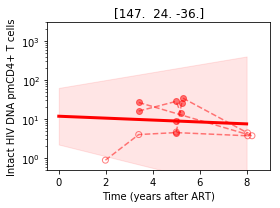

In [108]:

#run MEM
md = smf.mixedlm('lint ~ time_haart_days', df3, groups=df3['short_id'])
mdf = md.fit()
mem_results=[mdf.params[1],mdf.conf_int().iloc[1,0],mdf.conf_int().iloc[1,1],
             mdf.params[0],mdf.conf_int().iloc[0,0],mdf.conf_int().iloc[0,1]]

#plot total reservoir data relative to initiation of ART
tot_df=df3
dd='intact_corrected'
plt.figure(figsize=(4,3))
for ip,p in enumerate(tot_df['short_id'].unique()):
    tdf=tot_df[(tot_df['short_id']==p)]
    plt.plot(tdf['time_haart_days']/365,tdf[dd],color='red',ls='--',alpha=0.5)#cz_list[pind])
    plt.scatter(tdf['time_haart_days'][tdf['censoring']==0]/365,tdf[dd][tdf['censoring']==0],marker='o',alpha=0.5,color='red',edgecolor='red')#cz_list[pind])
    plt.scatter(tdf['time_haart_days'][tdf['censoring']==1]/365,tdf[dd][tdf['censoring']==1],marker='o',alpha=0.5,color='',edgecolor='red')#cz_list[pind])
plt.plot(simt,np.exp(mem_results[3]+mem_results[0]*simt*365),color='red',lw=3)
plt.fill_between(simt,np.exp(mem_results[4]+mem_results[1]*simt*365),np.exp(mem_results[5]+mem_results[2]*simt*365),color='red',alpha=0.1)
plt.ylabel('Intact HIV DNA pmCD4+ T cells')
plt.xticks(range(0,25,5))
plt.xlabel('Time (years after ART)')
plt.semilogy()
plt.ylim([0.5,3e3])
plt.xticks(range(0,23,2))
plt.xlim([-0.5,9])
plt.title(np.round(-np.log(2)/mem_results[:3]/365*12))
plt.tight_layout()    
plt.savefig('longitudinal_intact.pdf',dpi=600)

